### Scoring evaluation - irrelevant content included

The notebook illustrates the behavior of the scores as inferred by the service trained WITHOUT any irrelevant content.

It is meant to be compared with the variant trained on the irrelevant dataset together with others.

The used service is a result of training in stratified 5-CV splits, thus 1/5 of the data was left out of training.

In [1]:
from sklearn.externals import joblib
# from search_service import RelevanceSearchService
import numpy as np
import pandas as pd

In [2]:
scores_df = joblib.load("scores_pickled_w_none.dump")
scores_df.describe()

,None,amq,bpmsuite,brms,cdk,datagrid,developertoolset,devstudio,eap,fuse,openshift,rhel,softwarecollections,webserver
count,3.173900e+04,3.173900e+04,3.173900e+04,3.173900e+04,3.173900e+04,3.173900e+04,3.173900e+04,3.173900e+04,3.173900e+04,3.173900e+04,3.173900e+04,3.173900e+04,3.173900e+04,3.173900e+04
mean,1.551164e-01,3.155496e-02,2.340526e-02,2.338883e-02,2.561623e-03,1.844955e-02,8.618500e-05,1.338983e-01,3.012225e-01,1.627531e-01,1.032944e-01,5.951563e-02,4.663394e-05,3.066012e-02
std,3.489924e-01,8.185553e-02,9.189498e-02,8.012626e-02,2.217761e-02,6.532288e-02,2.614239e-03,2.734357e-01,3.683286e-01,3.142723e-01,2.655450e-01,2.100817e-01,3.554744e-04,8.207805e-02
min,4.158895e-13,1.770278e-11,7.206450e-09,1.146322e-08,2.212895e-08,1.234405e-07,2.072462e-07,1.029732e-13,6.408707e-12,1.034950e-12,2.118916e-12,2.220446e-16,6.473614e-07,1.634941e-09
25%,1.075082e-04,6.734496e-04,5.429224e-04,7.304667e-04,1.639039e-04,1.163467e-03,1.880643e-05,5.510478e-04,2.873960e-03,3.089547e-04,1.304257e-04,4.325647e-05,1.975662e-05,8.772694e-04
50%,5.976100e-04,3.937490e-03,2.190319e-03,3.570399e-03,4.558637e-04,3.828131e-03,3.186810e-05,6.223343e-03,5.761151e-02,4.229271e-03,1.206128e-03,3.527698e-04,3.171352e-05,4.476345e-03
75%,5.058933e-03,2.098234e-02,8.022597e-03,1.366208e-02,1.243209e-03,1.091321e-02,5.608108e-05,6.975258e-02,6.428323e-01,8.713254e-02,1.250312e-02,3.205731e-03,5.041045e-05,1.963038e-02
max,9.998135e-01,9.765582e-01,9.820622e-01,9.768457e-01,8.033322e-01,9.751234e-01,4.282121e-01,9.989427e-01,9.995448e-01,9.991852e-01,9.984707e-01,9.937770e-01,6.119643e-02,9.546645e-01


In [3]:
len(scores_df)

31739

In [4]:
# check of the tuned thresholds for categories

last_split_thresholds = joblib.load("last_split_thrds_w_none.dump")
last_split_thresholds

eap                    0.882789
fuse                   0.613757
None                   0.395490
devstudio              0.378884
openshift              0.267202
rhel                   0.352651
bpmsuite               0.060008
webserver              0.089542
brms                   0.057626
amq                    0.234900
datagrid               0.031458
cdk                    0.253278
developertoolset       0.999994
softwarecollections    0.999994
dtype: float64

In [5]:
# ScoreTuner instance used for evaluation of the results
from dependencies.scores_tuner import ScoreTuner
eval_score_tuner = ScoreTuner()
eval_score_tuner.cats_original_thresholds = last_split_thresholds

In [6]:
eval_score_tuner.precision_recall_for_category(scores_df["y"], scores_df["eap"], "eap", 0.5)

(0.9725330620549338, 0.710428536041615)

In [7]:
# true scores distribution for categories: 1. before tuning, 2. after tuning
true_docs_scores_tuned = pd.DataFrame(columns=["cat", "score"])

for cat in set(scores_df.columns)-{"y"}:
    new_scores = scores_df.ix[scores_df["y"]==cat, cat]
    new_cat = [cat]*len(new_scores)
    new_df = pd.DataFrame()
    new_df["score"] = new_scores
    new_df["cat"] = new_cat
    true_docs_scores_tuned = true_docs_scores_tuned.append(new_df)

### Scoring of the unseen documents towards their TRUE category

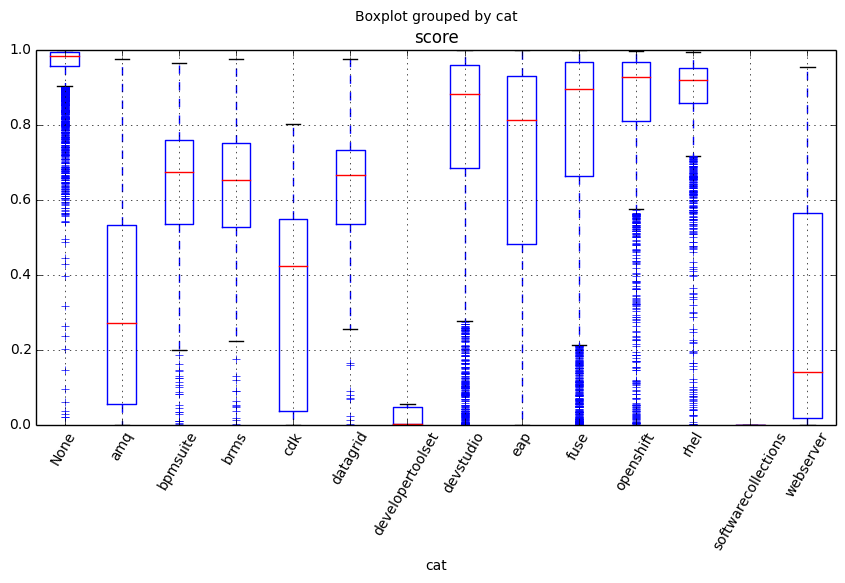

In [8]:
%matplotlib inline
true_docs_scores_tuned.boxplot("score", by="cat", figsize=(10,5), rot=60)

In [9]:
# TODO; true scores distribution for categories: 1. before tuning, 2. after tuning
false_docs_scores_tuned = pd.DataFrame(columns=["cat", "score"])

for cat in set(scores_df.columns)-{"y"}:
    new_scores = scores_df.ix[scores_df["y"]!=cat, cat]
    new_cat = [cat]*len(new_scores)
    new_df = pd.DataFrame()
    new_df["score"] = new_scores
    new_df["cat"] = new_cat
    false_docs_scores_tuned = false_docs_scores_tuned.append(new_df)

### Scoring of the unseen documents towards their FALSE categories

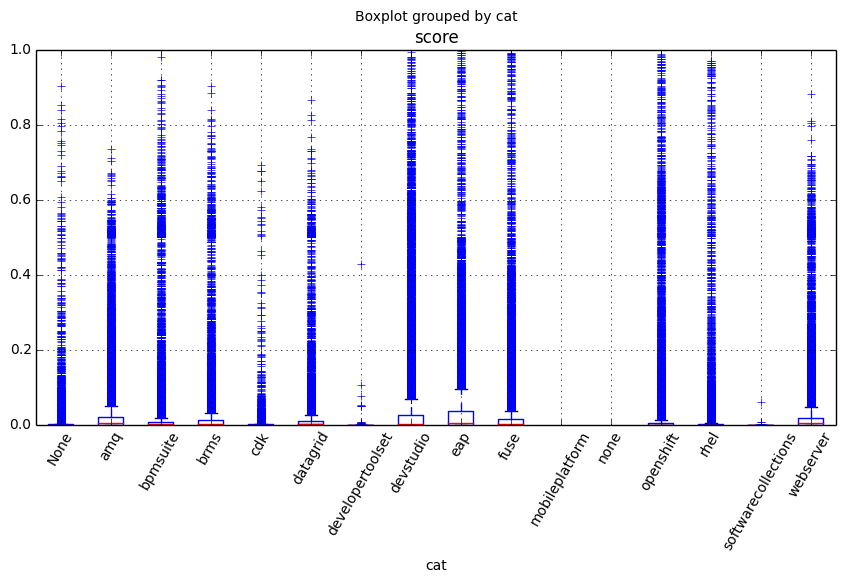

In [10]:
%matplotlib inline
false_docs_scores_tuned.boxplot("score", by="cat", figsize=(10,5), rot=60)

### Average scoring of the documents toward FALSE categories in relation to the content size

In [11]:
false_docs_scores_tuned["score"] = false_docs_scores_tuned["score"].apply(lambda x: float(x))

In [12]:
# false_docs_scores_tuned[false_docs_scores_tuned["cat"] == "none"]["cat"] = "None"

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [13]:
# drops off categories with on content in evaluation set if there are any
false_docs_scores_tuned = false_docs_scores_tuned.dropna(subset=["score"])

In [14]:
# negative mean scores for categories
cat_meta = pd.DataFrame(index=false_docs_scores_tuned["cat"].unique())
cat_meta["mean_score"] = false_docs_scores_tuned.groupby(by="cat").apply(np.mean)
cat_meta["cat_size"] = true_docs_scores_tuned.groupby(by="cat").count()
cat_meta.sort_values(by="cat_size")

,mean_score,cat_size
softwarecollections,0.000047,4
brms,0.020600,150
bpmsuite,0.019010,233
devstudio,0.051643,3583
None,0.005558,4996
cdk,0.002199,32
datagrid,0.016823,87
webserver,0.029404,153
fuse,0.033291,5503
amq,0.030573,98


### Performance evaluation of the system on original categories, excluding also categories with no scores in eval set

In [16]:
taken_categories = set(scores_df.columns) - {"none", "mobileplatform"}
scores_df_no_nans = scores_df.loc[scores_df["y"].isin(taken_categories), list(taken_categories)]
scores_df_filtered = scores_df_no_nans[list(taken_categories-{"y"})].applymap(float)
y_filtered = scores_df_no_nans["y"]

cats_betas = eval_score_tuner.beta_for_categories_provider(y_filtered)
categories = pd.Series(scores_df_filtered.columns)

cats_perf = categories.apply(lambda cat: eval_score_tuner.f_score_for_category(y_filtered, 
                                                                                   scores_df_filtered[cat], 
                                                                                   cat,
                                                                                   0.5,
                                                                                   cats_betas[cat]))
cats_perf.index = categories
# particular categories performance
cats_perf

2017-07-05 13:55:16,226 : WARNING : Categories f-score betas as scaled by cat sizes: 
eap                    0.2
fuse                   0.6
devstudio              1.0
openshift              1.4
rhel                   1.8
bpmsuite               2.2
webserver              2.6
brms                   3.0
amq                    3.4
datagrid               3.8
cdk                    4.2
developertoolset       4.6
softwarecollections    5.0
dtype: float64


softwarecollections    0.000000
brms                   0.704622
bpmsuite               0.675035
devstudio              0.838116
cdk                    0.438972
datagrid               0.749864
webserver              0.305833
fuse                   0.912806
rhel                   0.949764
amq                    0.350909
eap                    0.958926
developertoolset       0.000000
openshift              0.920340
dtype: float64

## Overall performance on relevant categories' dataset as defined in ScoreTuner:

In [17]:
eval_score_tuner.weighted_combine_cats_predictions(y_filtered, cats_perf)

2017-07-05 13:55:20,332 : WARNING : Cats performance weights: 
eap                    110.049989
fuse                    74.182208
devstudio               59.858166
openshift               54.763126
rhel                    42.249260
bpmsuite                15.264338
webserver               12.369317
brms                    12.247449
amq                      9.899495
datagrid                 9.327379
cdk                      5.656854
developertoolset         2.236068
softwarecollections      2.000000
Name: y, dtype: float64


0.4961427959785441

## Negative samples scoring

We evaluate the scoring towards categories on a content which is obviously not relevant to any of the categories
Here we attempt to reach the lowest possible score, optimally balanced amongst the categories.

We take the trained score service from the last split of the big dijunctive evaluation - service trained on 4/5 of content.

The service uses as unrelevant content the movie reviews dataset (25000 reviews) from IMDB.

Here, for evaluation on distinct negative sample we use a DB of 5000 political tweets from twitter.

The kind of eval dataset and its random marginal relevance towards the training categories might yield a certain level of bias to the scoring.

In [18]:
from search_service import RelevanceSearchService

In [20]:
eval_service = RelevanceSearchService()
eval_service.minimized_persistence = True
eval_service.load_trained_model("service_persisted_cv_split_w_none")

In [21]:
neg_samples_csv = pd.read_csv("../../data/experimental/eval_set/Political-media-DFE.csv")
neg_samples_csv["text"].head()

0    RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...
1    VIDEO - #Obamacare:  Full of Higher Costs and ...
2    Please join me today in remembering our fallen...
3    RT @SenatorLeahy: 1st step toward Senate debat...
4    .@amazon delivery #drones show need to update ...
Name: text, dtype: object

In [22]:
def take_first_n_words(text, n=5):
    n_words = text.split()[:n]
    return reduce(lambda w_one, w_two: "%s %s" % (w_one, w_two), n_words)

def replace_non_ascii(str):
    return ''.join([i if ord(i) < 128 else ' ' for i in str])

In [24]:
neg_samples_df = pd.DataFrame(columns=["id", "doc_header", "doc_content"])
# TODO: set limit here if needed
neg_samples_df[["id", "doc_content"]] = neg_samples_csv[["_unit_id", "text"]]
neg_samples_df["doc_header"] = neg_samples_df["doc_content"].apply(lambda content: take_first_n_words(content, n=5))
neg_samples_df["doc_content"] = neg_samples_df["doc_content"].apply(replace_non_ascii)
neg_samples_df["doc_header"] = neg_samples_df["doc_header"].apply(replace_non_ascii)
neg_samples_df.head()

,id,doc_header,doc_content
0,766192484,RT @nowthisnews: Rep. Trey Radel,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...
1,766192485,VIDEO - #Obamacare: Full of,VIDEO - #Obamacare: Full of Higher Costs and ...
2,766192486,Please join me today in,Please join me today in remembering our fallen...
3,766192487,RT @SenatorLeahy: 1st step toward,RT @SenatorLeahy: 1st step toward Senate debat...
4,766192488,.@amazon delivery #drones show need,.@amazon delivery #drones show need to update ...


In [35]:
neg_samples_scores, _ = eval_service.score_docs_bulk(neg_samples_df["id"], 
                                                  neg_samples_df["doc_header"], 
                                                  neg_samples_df["doc_content"])

In [36]:
%matplotlib inline

scores_norm_flattened = pd.DataFrame(columns=["cat", "score"])

for cat in eval_service.vector_classifier.classes_:
    new_scores = neg_samples_scores[cat]
    new_cat = [cat]*len(new_scores)
    new_df = pd.DataFrame()
    new_df["score"] = new_scores
    new_df["cat"] = new_cat
    scores_norm_flattened = scores_norm_flattened.append(new_df)

### Scoring of unrelevant content - political tweets - towards training categories

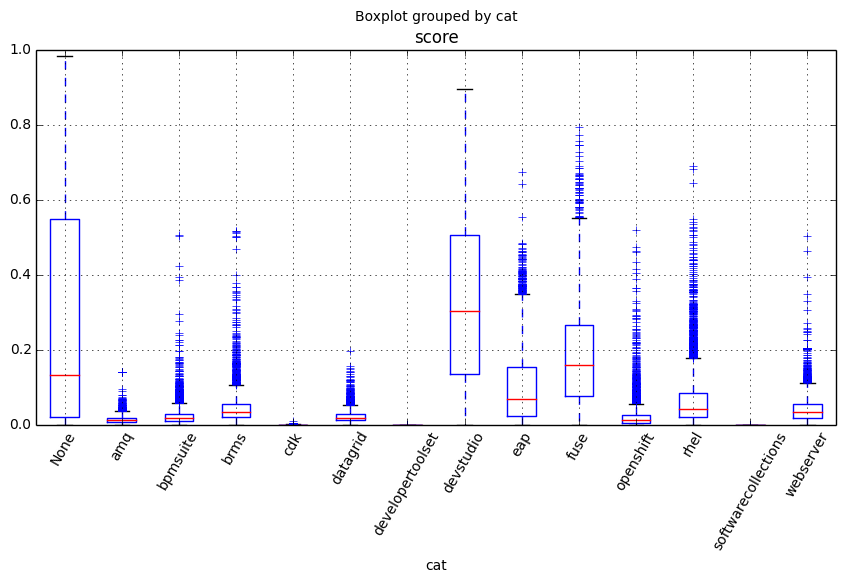

In [37]:
scores_norm_flattened.boxplot("score", by="cat", figsize=(10,5), rot=60)

In [42]:
# see that the devstudio scoring is incorrectly normalized upwards, 
# whereas the fuse and eap are learnt to correctly normalize down

eval_service.score_tuner.cats_original_thresholds

eap                    0.882789
fuse                   0.613757
None                   0.395490
devstudio              0.378884
openshift              0.267202
rhel                   0.352651
bpmsuite               0.060008
webserver              0.089542
brms                   0.057626
amq                    0.234900
datagrid               0.031458
cdk                    0.253278
developertoolset       0.999994
softwarecollections    0.999994
dtype: float64

This is to be compared with the service trained on purely-relevant categories' content. We attempt to push the scores for categories to push down as possible, and to evenly distribute the scores towards relevant categories